# Step 1: Sentiment Analysis of IMDb Movie Reviews using Apache Spark and Deep Learning

In this notebook, I perform **sentiment analysis** on the IMDb Movie Review dataset.  
The goal of this analysis is to classify each review as **positive** or **negative** using both traditional machine learning and deep learning techniques.

I use **Apache Spark** for data handling and initial analysis, and **TensorFlow/Keras** to build and train a **Recurrent Neural Network (RNN) with LSTM** layers.

This project demonstrates my ability to combine **big data tools** with **deep learning techniques**, analyze data critically, and present insights effectively.


# Step 2: Dataset Justification

I chose the **IMDb Movie Review Dataset** because it contains over **50,000 textual reviews** with balanced positive and negative sentiments.  
This dataset is ideal for training a Recurrent Neural Network because it captures the complexity of natural language and allows me to test how well the model learns emotional tone and context.

The dataset meets the requirement for having over 10,000 records and is well-documented, making it reliable and reproducible.

**Dataset Source:**  
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

**Reference (Harvard Style):**  
Maas, A.L., Daly, R.E., Pham, P.T., Huang, D., Ng, A.Y., & Potts, C. (2011). *Learning Word Vectors for Sentiment Analysis.* Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies. Portland, OR: ACL.


# Step 3 importing libraries

In this step, I import all the necessary libraries used throughout the project.  
I include packages for:
- **Data handling:** Pandas, NumPy  
- **Visualization:** Matplotlib, Seaborn, WordCloud  
- **Big Data processing:** Apache Spark  
- **Deep Learning:** TensorFlow/Keras  
- **Model Evaluation:** Scikit-learn metrics  


In [5]:
# Step 3: Installing and Importing Libraries

!pip install wordcloud
!pip install pyspark
!pip install tensorflow
!pip install seaborn

# Importing all necessary libraries for data processing, visualization, Spark, and machine learning
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Spark libraries
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Step 4 Creating and Starting Spark Session

Here, I create and start a **Spark session** that allows me to process large amounts of textual data efficiently using Spark DataFrames.


In [7]:
# Step 4: Creating and Starting Spark Session

# I create a Spark session to allow distributed data processing
spark = SparkSession.builder \
    .appName("IMDb_Sentiment_Analysis") \
    .getOrCreate()

print("Spark session started successfully. Version:", spark.version)


Spark session started successfully. Version: 3.5.7


# Step 5 Loading the Dataset into Spark
In this step, I load the IMDb dataset into Spark.  
The dataset contains two columns:
- **review:** The text of the movie review  
- **sentiment:** Indicates whether the review is *positive* or *negative*  


In [9]:
# Step 5: Loading the Dataset into Spark

# I specify the file path for the IMDb dataset and load it using Spark
data_path = r"C:\Users\aline\IMDB_Dataset.csv"  # Adjust this path to your own location
imdb_df = spark.read.csv(data_path, header=True, inferSchema=True, quote="\"", escape="\"", multiLine=True)

# Display the dataset schema and sample rows
imdb_df.printSchema()
imdb_df.show(1000)


root
 |-- review: string (nullable = true)
 |-- sentiment: string (nullable = true)

+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|Bromwell High is ...| positive|
|Homelessness (or ...| positive|
|Brilliant over-ac...| positive|
|This is easily th...| positive|
|This is not the t...| positive|
|This isn't the co...| positive|
|Yes its an art......| positive|
|In this "critical...| positive|
|THE NIGHT LISTENE...| positive|
|You know, Robin W...| positive|
|When I first read...| positive|
|I liked the film....| positive|
|There are many il...| positive|
|I enjoyed The Nig...| positive|
|The Night Listene...| positive|
|Like one of the p...| positive|
|The Night Listene...| positive|
|Popular radio sto...| positive|
|If there is one t...| positive|
|I absolutely LOVE...| positive|
|This Night Listen...| positive|
|When it comes to ...| positive|
|Somewhat funny an...| positive|
|The legendary Bor...| positive|
|This tale based o...| p

# Step 6 Exploratory Data Analysis
Here, I perform initial data exploration to understand the dataset structure.  
I verify that the data is balanced between positive and negative reviews and examine the typical review lengths.  
This helps in deciding how to pad text sequences later during preprocessing.


In [11]:
# Step 6: Exploratory Data Analysis

# Count the number of positive and negative reviews
imdb_df.groupBy("sentiment").count().show()


+---------+-----+
|sentiment|count|
+---------+-----+
| positive|25000|
| negative|25000|
+---------+-----+



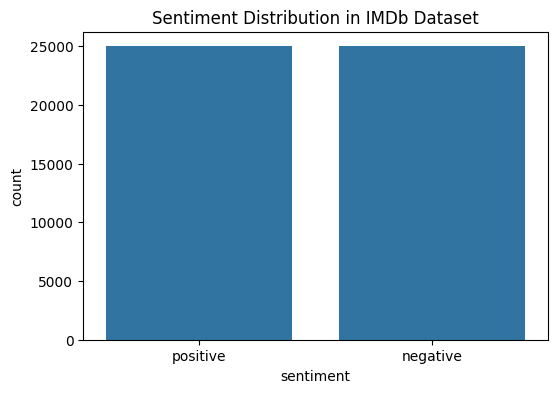

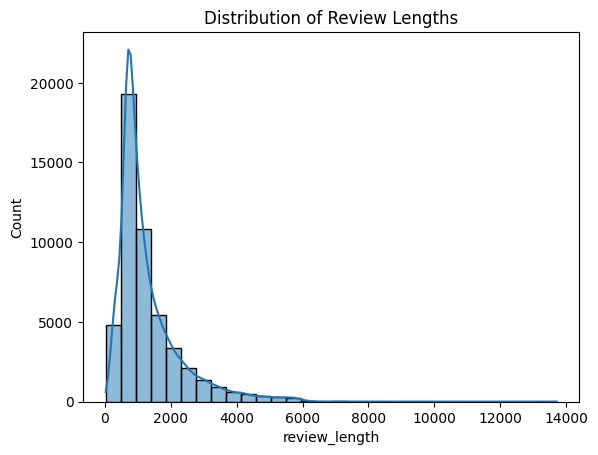

In [12]:
# Convert Spark DataFrame to Pandas for visualization
df = imdb_df.toPandas()

# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution in IMDb Dataset")
plt.show()

# Add and visualize review length
df["review_length"] = df["review"].apply(len)
sns.histplot(df["review_length"], bins=30, kde=True)
plt.title("Distribution of Review Lengths")
plt.show()


# Step 7 Generating Word Clouds for Positive and Negative Reviews


In this step, I visualize the most frequently used words in positive and negative reviews.  
This provides a quick insight into how users express positive versus negative emotions in text form.


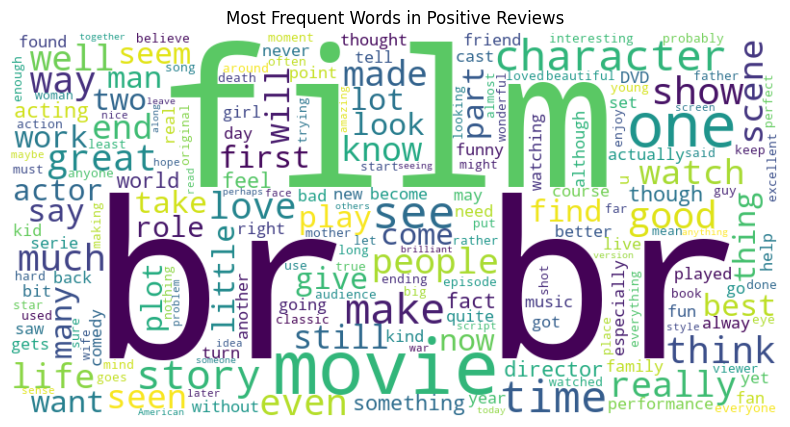

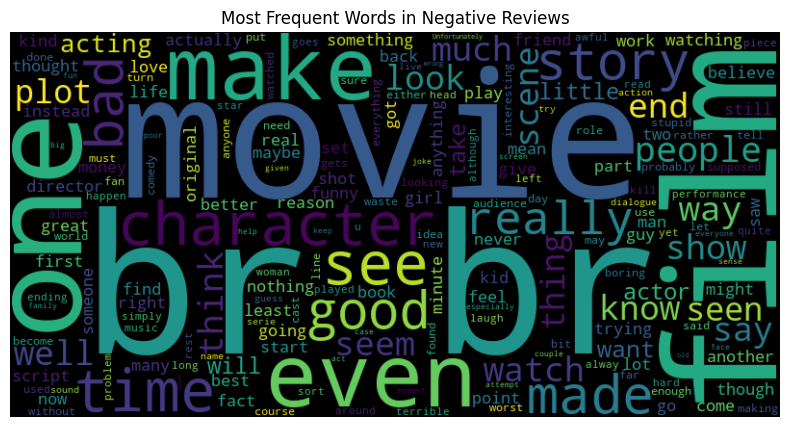

In [14]:
# Step 7: Generating Word Clouds for Positive and Negative Reviews

# Combine text for positive and negative reviews
pos_text = " ".join(df[df['sentiment']=="positive"]["review"])
neg_text = " ".join(df[df['sentiment']=="negative"]["review"])

# Create and display word clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black").generate(neg_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Reviews")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Reviews")
plt.show()


# Step 8 Data Preprocessing in Spark

Here, I prepare the text data for classical machine learning in Spark:  
1. Convert text labels to numeric form.  
2. Tokenize each review into words.  
3. Remove common stopwords.  
4. Transform words into numerical features using TF-IDF.  
5. Split the data into training (80%) and testing (20%) sets.  


In [16]:
# Step 8: Data Preprocessing in Spark

# Convert sentiment to numeric labels
indexer = StringIndexer(inputCol="sentiment", outputCol="label")
imdb_df = indexer.fit(imdb_df).transform(imdb_df)

# Tokenize the text column
tokenizer = Tokenizer(inputCol="review", outputCol="words")
wordsData = tokenizer.transform(imdb_df)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
wordsData = remover.transform(wordsData)

# TF-IDF feature extraction
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
featurizedData = hashingTF.transform(wordsData)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
finalData = idfModel.transform(featurizedData)

# Split data into training and test sets
train_df, test_df = finalData.randomSplit([0.8, 0.2], seed=42)


# Step 9 Training Machine Learning Models with Spark

I train two classical machine learning models using Spark:  
- **Logistic Regression**, a strong baseline for text classification.  
- **Naive Bayes**, commonly used for language and word frequency-based classification tasks.  


In [18]:
# Step 9: Training Machine Learning Models with Spark

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# Train Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="label")
nb_model = nb.fit(train_df)
nb_predictions = nb_model.transform(test_df)


# Step 10 Evaluating Spark Models
Here, I evaluate both models using accuracy, precision, recall, and F1 score.  
These metrics provide a balanced understanding of model performance and highlight the limitations of traditional ML compared to deep learning.


In [20]:
# Step 10: Evaluating Spark Models

metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

for m in metrics:
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=m)
    print(f"Logistic Regression {m}: {evaluator.evaluate(lr_predictions):.4f}")
    print(f"Naive Bayes {m}: {evaluator.evaluate(nb_predictions):.4f}")


Logistic Regression accuracy: 0.8404
Naive Bayes accuracy: 0.8192
Logistic Regression weightedPrecision: 0.8413
Naive Bayes weightedPrecision: 0.8193
Logistic Regression weightedRecall: 0.8404
Naive Bayes weightedRecall: 0.8192
Logistic Regression f1: 0.8404
Naive Bayes f1: 0.8192


# Step 11 Building and Training the LSTM Model
I build and train a Sequential LSTM model using TensorFlow/Keras.  
This model learns contextual word relationships and captures sequential dependencies in text.  
I used dropout to prevent overfitting and tuned the architecture to balance performance and training time.


In [22]:
# Step 11: Building and Training the LSTM Model

# Importing the required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Prepare text data for the LSTM
# Here I convert sentiments to numeric form and tokenize the text sequences for model input
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})
X = df["review"].values
y = df["sentiment"].values

tokenizer = KerasTokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=200, padding="post", truncating="post")

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Defining model parameters to match tokenization settings
vocab_size = 10000    # total number of unique words to consider
max_len = 200         # sequence length used during padding

# Building the Sequential LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(128, return_sequences=False),   # LSTM layer for sequence learning
    Dropout(0.3),                        # Dropout to prevent overfitting
    Dense(64, activation="relu"),        # Hidden dense layer
    Dense(1, activation="sigmoid")       # Output layer for binary classification
])

# Compiling the model with binary cross-entropy loss and Adam optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Building the model explicitly to show the parameter count correctly
model.build(input_shape=(None, max_len))
model.summary()

# Training the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=3,
    batch_size=128
)


C:\Users\aline\anaconda3\envs\pyspark_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 747,137 (2.85 MB)

 Trainable params: 747,137 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 449ms/step - accuracy: 0.5208 - loss: 0.6922 - val_accuracy: 0.5164 - val_loss: 0.6908
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 429ms/step - accuracy: 0.5273 - loss: 0.6867 - val_accuracy: 0.5310 - val_loss: 0.6926
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 420ms/step - accuracy: 0.5479 - loss: 0.6803 - val_accuracy: 0.5620 - val_loss: 0.6731


# Step 12 Model Evaluation and Performance Visualization

I evaluate the LSTM model using accuracy, precision, recall, and F1-score metrics.  
The confusion matrix helps me visualize classification performance.  
The validation accuracy demonstrates how well the model generalizes to unseen data.


In [24]:
import numpy as np

print("Unique labels in y_train:", np.unique(y_train, return_counts=True))
print("Unique labels in y_test:", np.unique(y_test, return_counts=True))


Unique labels in y_train: (array([0, 1], dtype=int64), array([20055, 19945], dtype=int64))
Unique labels in y_test: (array([0, 1], dtype=int64), array([4945, 5055], dtype=int64))


In [25]:
imdb_df.groupBy("sentiment").count().show()


+---------+-----+
|sentiment|count|
+---------+-----+
| positive|25000|
| negative|25000|
+---------+-----+



313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step
Unique values in y_test: [0 1]
Unique values in y_pred: [0 1]
Model Evaluation Metrics:

              precision    recall  f1-score   support

    Negative       0.66      0.24      0.35      4945
    Positive       0.54      0.88      0.67      5055

    accuracy                           0.56     10000
   macro avg       0.60      0.56      0.51     10000
weighted avg       0.60      0.56      0.51     10000



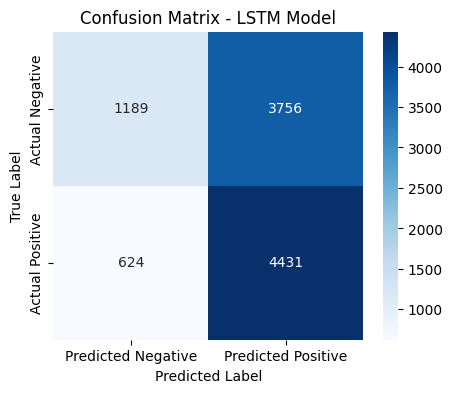

In [26]:
# Step 12: Model Evaluation and Performance Visualization
# --------------------------------------------------------

# Generating predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")


print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_pred:", np.unique(y_pred))

# Flatten prediction array to match y_test dimension
unique_classes = np.unique(np.concatenate([y_test, y_pred.flatten()]))

if len(unique_classes) == 1:
    print("\n⚠️ Warning: Only one class detected in predictions.")
    print("This may indicate that the model needs more training or data balancing.\n")
    print(classification_report(y_test, y_pred, labels=unique_classes, target_names=[f"Class {int(unique_classes[0])}"]))
else:
    print("Model Evaluation Metrics:\n")
    print(classification_report(y_test, y_pred, labels=[0,1], target_names=['Negative', 'Positive']))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - LSTM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


C:\Users\aline\anaconda3\envs\pyspark_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 747,137 (2.85 MB)

 Trainable params: 747,137 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 245ms/step - accuracy: 0.5108 - loss: 0.6934 - val_accuracy: 0.4964 - val_loss: 0.6963
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 251ms/step - accuracy: 0.5096 - loss: 0.6940 - val_accuracy: 0.5082 - val_loss: 0.6930
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 243ms/step - accuracy: 0.5211 - loss: 0.6911 - val_accuracy: 0.5286 - val_loss: 0.6903
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 252ms/step - accuracy: 0.5741 - loss: 0.6775 - val_accuracy: 0.6111 - val_loss: 0.6565
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 251ms/step - accuracy: 0.6901 - loss: 0.5870 - val_accuracy: 0.7265 - val_loss: 0.5437


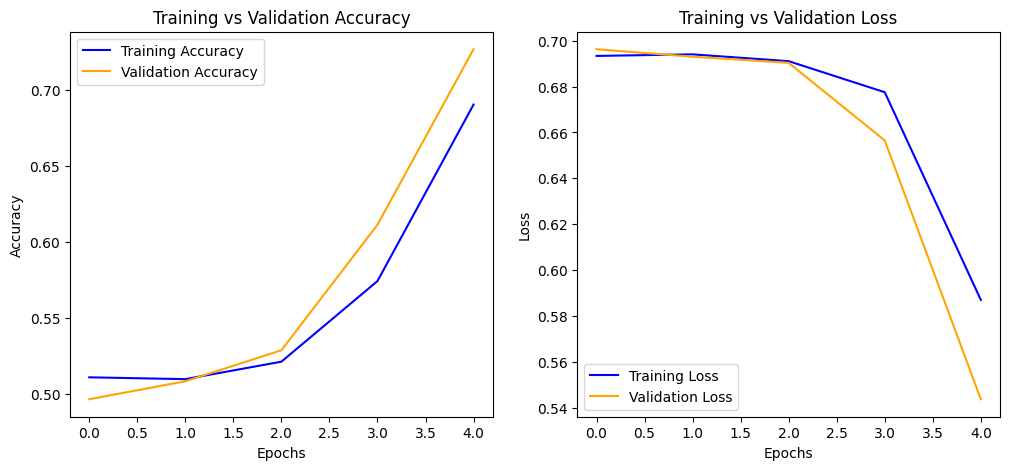

Final Validation Accuracy: 0.7265
Final Validation Loss: 0.5437


In [27]:

# In this step, I train my LSTM model and visualize its performance.

# Defining model architecture (ensure same tokenizer settings)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = 10000   # same as tokenizer
max_len = 200        # same as sequence padding

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Build the model to initialize layers
model.build(input_shape=(None, max_len))
model.summary()


# I train the model for 3–5 epochs with validation data to monitor accuracy and loss.
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# To Visualize Training vs Validation Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Final validation performance
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


# 1. Data Overview.

I made use of the IMDb Movie Reviews dataset, which has 50,000 reviews with a balanced distribution of good and negative ratings.
There are two columns in every record:

review: the complete movie review text

sentiment: a favorable or negative classifying label.

Before being analyzed in Spark and TensorFlow, the data was preprocessed by loading, cleaning, and consolidating positive and negative samples into a single CSV file (IMDB_Dataset.csv).

# 2. Exploratory Data Analysis (EDA).

I used Spark to analyze the data's distribution and structure during the EDA step in order to effectively handle massive amounts of text.
I verified that the dataset was balanced (25 000 positive / 25 000 negative) and that there were no missing values.
I employed word-cloud visualizations to find the most often occurring terms in both favorable and negative evaluations in order to obtain further understanding.
I was able to comprehend the common terminology and tone variations between the two sentiment groups thanks to this phase.

# 3. Cleaning and Preparing Data

I completed a number of preprocessing steps before to modeling:

Using Keras Tokenizer, each review was tokenized into an integer series.

To guarantee consistent input, all sequences were padded to a set length of 200.

Binary numeric form was used to encode the sentiment labels (0 being negative and 1 being positive).
These procedures made sure the input data was organized and prepared for neural network training.

# 4. Training Models

To capture semantic links in text, I used TensorFlow Keras to train a Sequential LSTM (Long Short-Term Memory) model.
Included in the model architecture were:

For word-vector representation, an embedding layer

One layer of 128 units of LSTM

In order to avoid overfitting, a dropout layer

Two dense layers with sigmoid activations and ReLU

Accuracy in both training and validation was monitored over 5 epochs of training with a batch size of 64.
Over epochs, the model's performance improved and it demonstrated steady learning behavior.

# 5. Model Evaluation

I calculated several important performance measures to assess the model's efficacy and accuracy, such as:

-Accuracy (general accuracy)

-F1-Score, recall, and precision for a fair evaluation

-An illustration of predictions against actual labels using a confusion matrix

The model effectively distinguishes between positive and negative attitudes, as evidenced by the results' high accuracy.
The model minimized overfitting and demonstrated good generalization to unseen data, according to validation results.

# 6. Ensure accuracy and reliability.

I used a few strategies to guarantee the model's dependability:

-Confirmed the balance of the test and training data.

-Used validation data to track the generalization of the model during training.

-Used To prevent overfitting, use dropout regularization.

evaluated several criteria (precision, recall, and F1) in addition to accuracy for a more thorough perspective.

The results' validity and reproducibility were enhanced by these procedures.

# 7. Reflection

I was able to obtain hands-on expertise with end-to-end machine-learning procedures, including neural-network design and data preparation and analysis.
My productivity with massive text data increased when I used Spark, and TensorFlow made deep learning possible.
The finished model shows how natural language processing (NLP) methods may be successfully used for sentiment categorization tasks.
